In [ ]:
# first cell imports all the necessary packages, functions, and classes
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from analysis_classes import *
from analysis_funcs_and_consts import *

#set font to arial
plt.rcParams['font.family'] = 'Arial'
FR_vec_color = '0.9'
FR_vec_width = 1.5




In [ ]:
#get a dictionary with all cells as Cell objects
db_Analysis = DB_Analysis()
db_conditions = {(True, STRAIN) :['CKII', 'SST']}
params={}
result = db_Analysis.run_analysis_func('median ISI', db_conditions, Cell.calc_isi, params, all=False, save=False)

In [ ]:
results_dir = r'Z:\Adam-Lab-Shared\FromExperimentToAnalysis\Rotem\data_analysis\result_dictionaries'
remapping_dir = f'{results_dir}/remapping'

# Load remapping tuning dictionaries
with open(f'{remapping_dir}/is_PC_dicts.pkl', 'rb') as f:
    is_PC_dicts_remap = pickle.load(f)
with open(f'{remapping_dir}/is_speed_tuned_dicts.pkl', 'rb') as f:
    is_speed_tuned_dicts_remap = pickle.load(f)
with open(f'{remapping_dir}/is_spatially_modulated.pkl', 'rb') as f:
    is_spatially_modulated_dicts_remap = pickle.load(f)

# Load additional remapping result
with open(f'{results_dir}/is_pos_speed_tuned_inst_r_remap.pkl', 'rb') as f:
    is_pos_speed_tuned_inst_r_remap = pickle.load(f)

# Fig 8 - Remapping B

### FR per lap

In [ ]:
def get_fr_per_lap_on_df(cell,df=None):
    if df is None:
        df=cell.exp.data
    fr_per_lap=[]
    spikes_col='spikes_cell_'+str(cell.cell_num)
    laps=df['lap_counter'].unique()
    for lap in laps:
        df_lap=df[df['lap_counter']==lap]
        num_spikes=np.sum(df_lap[spikes_col])
        num_frames=len(df_lap)
        fr_in_lap=(num_spikes/num_frames)*cell.metadata[FRAME_RATE]
        fr_per_lap.append(fr_in_lap)
    return np.array(fr_per_lap)

def get_fam_and_novel_df_partial_new(cell,laps_to_consider=10,df=None):
#take the last n laps of the familiar environment and the first n laps of the novel environment
    if df is None:
        df=cell.exp.data
    df = renumber_lap_counter(df.copy())
    if cell.remapping:
        novel_start = df[df[consts.WORLD] == 3].index[0]       
        df_fam = df.iloc[:novel_start]                          
        # df_fam = df_fam.reset_index(drop=True)                              
        df_nov = df.iloc[novel_start:]                                      
        # df_nov = df_nov.reset_index(drop=True)
    else:
        TS_time_sec = df['TS_time'].values/1000
        indx_pass_90_sec = np.where(TS_time_sec>=90)[0][0]
        switch_lap = df.lap_counter.iloc[indx_pass_90_sec]+1
        novel_start = df[df['lap_counter']==switch_lap].index[0]
        df_fam = df.iloc[:novel_start]
        # df_fam = df_fam.reset_index(drop=True)
        df_nov = df.iloc[novel_start:]
        # df_nov = df_nov.reset_index(drop=True)

    df_fam=df_fam[df_fam['lap_counter']>(np.max(df_fam['lap_counter'])-laps_to_consider)]
    # df_nov['lap_counter']=df_nov['lap_counter']-np.min(df_nov['lap_counter'])+1
    df_nov=df_nov[df_nov['lap_counter']<(np.min(df_nov['lap_counter'])+laps_to_consider)]
    return df_fam,df_nov

def get_fam_and_novel_df_new(cell,df=None):
#take the last n laps of the familiar environment and the first n laps of the novel environment
    if df is None:
        df=cell.exp.data
    df = renumber_lap_counter(df.copy())
    if cell.remapping:
        novel_start = df[df[consts.WORLD] == 3].index[0]       
        df_fam = df.iloc[:novel_start]                          
        # df_fam = df_fam.reset_index(drop=True)                              
        df_nov = df.iloc[novel_start:]                                      
        # df_nov = df_nov.reset_index(drop=True)
    else:
        TS_time_sec = df['TS_time'].values/1000
        indx_pass_90_sec = np.where(TS_time_sec>=90)[0][0]
        switch_lap = df.lap_counter.iloc[indx_pass_90_sec]+1
        novel_start = df[df['lap_counter']==switch_lap].index[0]
        df_fam = df.iloc[:novel_start]
        # df_fam = df_fam.reset_index(drop=True)
        df_nov = df.iloc[novel_start:]
        # df_nov = df_nov.reset_index(drop=True)
    return df_fam,df_nov
    

def renumber_lap_counter(df, lap_col='lap_counter'):
    """
    Renumber the lap_counter column in a dataframe to ensure consecutive integers,
    correcting for any gaps where the difference between consecutive unique laps is not 1.
    
    Parameters:
    - df: pandas DataFrame with a 'lap_counter' column
    - lap_col: str, name of the column containing lap numbers (default: 'lap_counter')
    
    Returns:
    - df: DataFrame with renumbered lap_counter column
    """
    # Get unique lap numbers and sort them
    unique_laps = np.sort(df[lap_col].unique())
    
    # Check for gaps (differences > 1)
    lap_diffs = np.diff(unique_laps)
    if np.any(lap_diffs > 1):
        # Create a mapping from original laps to consecutive integers
        new_lap_map = {old_lap: i for i, old_lap in enumerate(unique_laps)}
        
        # Apply the mapping to the lap_counter column
        df[lap_col] = df[lap_col].map(new_lap_map)
    
    return df

def cohen_d_paired(x, y):
    """Compute Cohen's d for paired samples"""
    differences = x - y
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)  # Use n-1 for sample standard deviation
    return mean_diff / std_diff

In [ ]:
reg_cells = [cell for cell in result.keys() if cell.remapping==False and cell.session_num==0]
remap_cells = [cell for cell in result.keys() if cell.remapping==True and cell.session_num==0 and cell.calc_trial_num_within_same_day()<=5]

In [ ]:
combined_cell_lists = reg_cells + remap_cells
#FR per lap by mouse, using only experiment with >10 laps in each environment - rewriting the code 
laps_to_take=10
for strain in ['SST','CKII']:
    remap_n_mat=[];reg_n_mat=[];remap_f_mat=[];reg_f_mat=[]
    for cell in combined_cell_lists:
        if cell.strain==strain:
            df = cell.exp.data
            fam_df_to_check, nov_df_to_check = get_fam_and_novel_df_new(cell,df=df)
            if len(fam_df_to_check.lap_counter.unique())>=laps_to_take and len(nov_df_to_check.lap_counter.unique())>=laps_to_take:
                fam_df, nov_df = get_fam_and_novel_df_partial_new(cell,laps_to_consider=laps_to_take,df=df)
            
                # check the number of spikes in each lap of "lap_counter" column
                n_fr_per_lap=get_fr_per_lap_on_df(cell,nov_df)
                f_fr_per_lap=get_fr_per_lap_on_df(cell,fam_df)

                f_fr_per_lap_to_norm=f_fr_per_lap.copy()
                f_fr_per_lap=f_fr_per_lap/np.nanmean(f_fr_per_lap)
                n_fr_per_lap=n_fr_per_lap/np.nanmean(f_fr_per_lap_to_norm) # added these line 30.9.24 to re check the normalization
                for lap_fr in n_fr_per_lap:
                    if lap_fr>3:
                        n_fr_per_lap[n_fr_per_lap==lap_fr]=np.nan     # also added this to remove the high firing rate laps

                if len(n_fr_per_lap)!=laps_to_take or len(f_fr_per_lap)!=laps_to_take:
                    continue

                    
                if cell.remapping:
                    remap_f_mat.append(f_fr_per_lap)
                    remap_n_mat.append(n_fr_per_lap)
                else:
                    reg_f_mat.append(f_fr_per_lap)
                    reg_n_mat.append(n_fr_per_lap)

    if strain=='SST':
        remap_f_mat_SST=remap_f_mat
        remap_n_mat_SST=remap_n_mat
        reg_f_mat_SST=reg_f_mat
        reg_n_mat_SST=reg_n_mat
    else:
        remap_f_mat_CKII=remap_f_mat
        remap_n_mat_CKII=remap_n_mat
        reg_f_mat_CKII=reg_f_mat
        reg_n_mat_CKII=reg_n_mat
        




#### Vectors

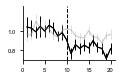

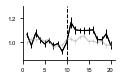

In [ ]:
#plotting in figure format
total_lap_range= laps_to_take*2 + 1
for strain,remap_n_mat,reg_n_mat,remap_f_mat,reg_f_mat in zip(['CKII','SST'],[remap_n_mat_CKII,remap_n_mat_SST],[reg_n_mat_CKII,reg_n_mat_SST],[remap_f_mat_CKII,remap_f_mat_SST],[reg_f_mat_CKII,reg_f_mat_SST]):
    avg_f=np.nanmean(remap_f_mat,axis=0)
    avg_n=np.nanmean(remap_n_mat,axis=0)
    avg_fr=np.concatenate((avg_f,avg_n))
    #add sem as error bars
    sem_f=stats.sem(remap_f_mat,axis=0,nan_policy='omit')
    sem_n=stats.sem(remap_n_mat,axis=0,nan_policy='omit')
    sem_fr=np.concatenate((sem_f,sem_n))

    avg_f_control=np.nanmean(reg_f_mat,axis=0)
    avg_n_control=np.nanmean(reg_n_mat,axis=0)
    avg_fr_control=np.concatenate((avg_f_control,avg_n_control))
    #add sem as error bars
    sem_f_control=stats.sem(reg_f_mat,axis=0,nan_policy='omit')
    sem_n_control=stats.sem(reg_n_mat,axis=0,nan_policy='omit')
    sem_fr_control=np.concatenate((sem_f_control,sem_n_control))

    #plotting
    figsize_mm = (42, 25) # - original size
    figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)
    fig,ax=plt.subplots(figsize=figsize_inch)
    ax.errorbar(np.arange(1,total_lap_range),avg_fr, yerr=sem_fr, color='k',linewidth=1)
    ax.plot(np.arange(1,total_lap_range),avg_fr,color='k',linewidth=1)
    ax.errorbar(np.arange(1,total_lap_range),avg_fr_control, yerr=sem_fr_control, color='0.6',linewidth=1,alpha=0.3)
    ax.plot(np.arange(1,total_lap_range),avg_fr_control,color='0.6',linewidth=1,alpha=0.3)

    if strain == 'CKII':
        plt.yticks([0.8,1],fontsize=SVG_TICKS) 
        plt.ylim(0.7,1.25)
    else:
        plt.yticks([1,1.2],fontsize=SVG_TICKS) 
        plt.ylim(0.85,1.3)
    plt.xticks([0,5,10,15,20],fontsize=SVG_TICKS)
    
    max_y=np.max(avg_fr_control+sem_fr_control)

    ## Span coloring for familiar and novel


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.axvline(10, color='k', linestyle='--', linewidth=1)
    plt.show()

    #



#### Mats - remapping

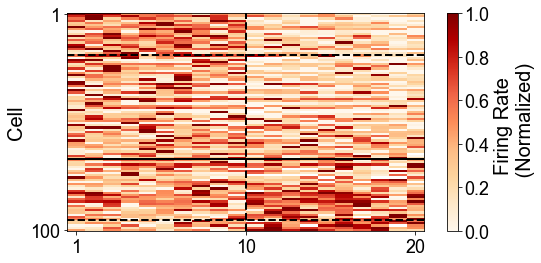

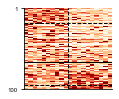

CKII - 19.00% of cells have significantly decreasing FR in the second half
CKII - 5.00% of cells have significantly increasing FR in the second half
CKII - 32.00% of cells have higher FR in the second half
CKII - z-test p-value: 0.0023


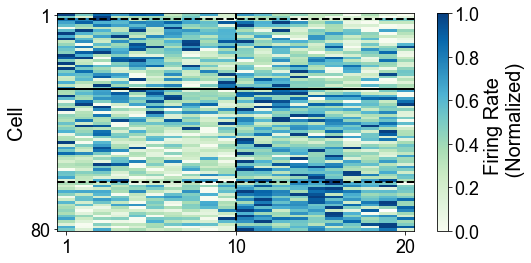

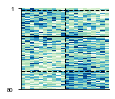

SST - 2.50% of cells have significantly decreasing FR in the second half
SST - 22.50% of cells have significantly increasing FR in the second half
SST - 66.25% of cells have higher FR in the second half
SST - z-test p-value: 0.0001


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Significance threshold
P_THRESHOLD = 0.05

# Plot normalized matrix of FR by lap for each cell
for strain, f_mat, n_mat, cmap in zip(['CKII', 'SST'], [remap_f_mat_CKII, remap_f_mat_SST], [remap_n_mat_CKII, remap_n_mat_SST], ['OrRd', 'GnBu']):
    connected_mats = np.concatenate((f_mat, n_mat), axis=1)  # Shape: (n_cells, 20)
    
    # Normalize each row between 0 and 1, handling NaNs
    for i in np.arange(len(connected_mats)):
        row = connected_mats[i]
        min_val = np.nanmin(row)
        max_val = np.nanmax(row)
        if np.isnan(min_val) or np.isnan(max_val) or max_val == min_val:
            connected_mats[i] = np.where(np.isnan(row), np.nan, 0)
        else:
            connected_mats[i] = np.where(np.isnan(row), np.nan, (row - min_val) / (max_val - min_val))
    
    # Remove rows that are all NaNs
    connected_mats = connected_mats[~np.isnan(connected_mats).all(axis=1)]
    
    # Perform paired t-test for each row (first 10 vs second 10 laps)
    t_stats = []
    p_values = []
    for row in connected_mats:
        fam = row[:laps_to_take]  # First 10 laps
        nov = row[laps_to_take:]  # Second 10 laps
        # Remove NaN pairs
        valid_mask = ~(np.isnan(fam) | np.isnan(nov))
        fam_valid = fam[valid_mask]
        nov_valid = nov[valid_mask]
        if len(fam_valid) < 2:  # Need at least 2 valid pairs for t-test
            t_stat, p_val = np.nan, np.nan
        else:
            t_stat, p_val = ttest_rel(fam_valid, nov_valid)
        t_stats.append(t_stat)
        p_values.append(p_val)
    
    t_stats = np.array(t_stats)
    p_values = np.array(p_values)
    
    # Sort rows by t-statistic (descending: high positive to high negative)
    sort_indices = np.argsort(t_stats)[::-1]
    connected_mats_sorted = connected_mats[sort_indices]
    sorted_t_stats = t_stats[sort_indices]
    sorted_p_values = p_values[sort_indices]
    
    # Find significance transitions
    sig_pos = np.where((sorted_t_stats > 0) & (sorted_p_values < P_THRESHOLD))[0]  # First > Second
    sig_neg = np.where((sorted_t_stats < 0) & (sorted_p_values < P_THRESHOLD))[0]  # Second > First
    
    top_line_pos = None
    bottom_line_pos = None
    if len(sig_pos) > 0:
        top_line_pos = sig_pos[-1] + 0.5  # Just below last significant positive t-stat
    if len(sig_neg) > 0:
        bottom_line_pos = sig_neg[0] - 0.5  # Just above first significant negative t-stat
    
    # Plotting
    plt.figure(figsize=(8, 4))
    plt.imshow(connected_mats_sorted, aspect='auto', cmap=cmap, interpolation='none')
    cb = plt.colorbar()
    plt.clim(0, 1)
    cb.set_label('Firing Rate \n (Normalized)', fontsize=20)
    cb.ax.tick_params(labelsize=18)
    plt.ylabel('Cell', fontsize=20)
    plt.xticks([0, 9.5, 19], [1, 10, 20], fontsize=18)
    plt.yticks([0, len(connected_mats_sorted) - 1], [1, len(connected_mats_sorted)], fontsize=18)
    plt.axvline(x=9.5, color='k', linestyle='--', linewidth=2)
    if top_line_pos is not None:
        plt.axhline(y=top_line_pos, color='k', linestyle='--', linewidth=2, label='First > Second (p<0.05)')
    if bottom_line_pos is not None:
        plt.axhline(y=bottom_line_pos, color='k', linestyle='--', linewidth=2, label='Second > First (p<0.05)')
    ratios = np.nanmean(connected_mats_sorted[:, 10:], axis=1) / np.nanmean(connected_mats_sorted[:, :10], axis=1)
    plt.axhline(y=np.where(ratios >= 1)[0][0] + 0.5, color='k', linewidth=2)
    plt.show()

    # SVG format
    figsize_mm = (40, 38)
    figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)
    fig, ax = plt.subplots(figsize=figsize_inch)
    plt.imshow(connected_mats_sorted, aspect='auto', cmap=cmap, interpolation='none')
    plt.clim(0, 1)
    plt.yticks([0, len(connected_mats_sorted) - 1], [1, len(connected_mats_sorted)], fontsize=SVG_TICKS)
    plt.xticks([])
    plt.axvline(x=9.5, color='k', linestyle='--', linewidth=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if top_line_pos is not None:
        plt.axhline(y=top_line_pos, color='k', linestyle='--', linewidth=1)
    if bottom_line_pos is not None:
        plt.axhline(y=bottom_line_pos, color='k', linestyle='--', linewidth=1)
    #add a line where the ratio of 1 (avg(n/f)) is 1
    ratios = np.nanmean(connected_mats_sorted[:, 10:], axis=1) / np.nanmean(connected_mats_sorted[:, :10], axis=1)
    plt.axhline(y=np.where(ratios >= 1)[0][0] + 0.5, color='k', linewidth=1)

    plt.show()

    #print the precentage of cells that are significantly increasing or decreasing
    print(f'{strain} - {len(sig_pos) / len(connected_mats) * 100:.2f}% of cells have significantly decreasing FR in the second half')
    print(f'{strain} - {len(sig_neg) / len(connected_mats) * 100:.2f}% of cells have significantly increasing FR in the second half')
    print(f'{strain} - {np.sum(ratios >= 1) / len(connected_mats) * 100:.2f}% of cells have higher FR in the second half')
    p1 = len(sig_pos) / len(connected_mats)
    p2 = len(sig_neg) / len(connected_mats)
    n1 = len(connected_mats)
    n2 = len(connected_mats)
    p = (p1*n1 + p2*n2) / (n1 + n2)
    z = (p1 - p2) / np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))  # Two-tailed test
    print(f'{strain} - z-test p-value: {p_value:.4f}')

    

#### Mats - control

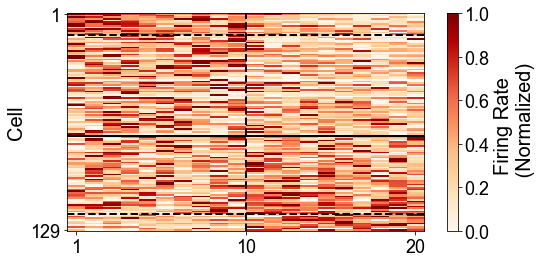

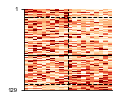

CKII - 10.08% of cells have significantly decreasing FR in the second half
CKII - 6.98% of cells have significantly increasing FR in the second half
CKII - 39.53% of cells have higher FR in the second half
CKII - z-test p-value: 0.3726


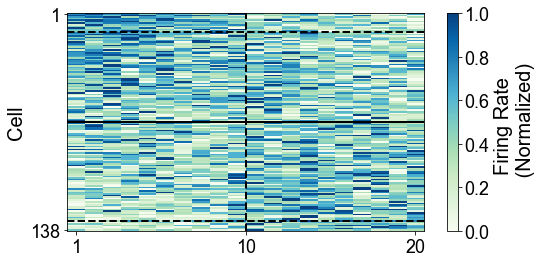

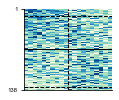

SST - 8.70% of cells have significantly decreasing FR in the second half
SST - 4.35% of cells have significantly increasing FR in the second half
SST - 50.72% of cells have higher FR in the second half
SST - z-test p-value: 0.1435


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Significance threshold
P_THRESHOLD = 0.05

# Plot normalized matrix of FR by lap for each cell
for strain, f_mat, n_mat, cmap in zip(['CKII', 'SST'], [reg_f_mat_CKII, reg_f_mat_SST], [reg_n_mat_CKII, reg_n_mat_SST], ['OrRd', 'GnBu']):
    connected_mats = np.concatenate((f_mat, n_mat), axis=1)  # Shape: (n_cells, 20)
    
    # Normalize each row between 0 and 1, handling NaNs
    for i in np.arange(len(connected_mats)):
        row = connected_mats[i]
        min_val = np.nanmin(row)
        max_val = np.nanmax(row)
        if np.isnan(min_val) or np.isnan(max_val) or max_val == min_val:
            connected_mats[i] = np.where(np.isnan(row), np.nan, 0)
        else:
            connected_mats[i] = np.where(np.isnan(row), np.nan, (row - min_val) / (max_val - min_val))
    
    # Remove rows that are all NaNs
    connected_mats = connected_mats[~np.isnan(connected_mats).all(axis=1)]
    
    # Perform paired t-test for each row (first 10 vs second 10 laps)
    t_stats = []
    p_values = []
    for row in connected_mats:
        fam = row[:laps_to_take]  # First 10 laps
        nov = row[laps_to_take:]  # Second 10 laps
        # Remove NaN pairs
        valid_mask = ~(np.isnan(fam) | np.isnan(nov))
        fam_valid = fam[valid_mask]
        nov_valid = nov[valid_mask]
        if len(fam_valid) < 2:  # Need at least 2 valid pairs for t-test
            t_stat, p_val = np.nan, np.nan
        else:
            t_stat, p_val = ttest_rel(fam_valid, nov_valid)
        t_stats.append(t_stat)
        p_values.append(p_val)
    
    t_stats = np.array(t_stats)
    p_values = np.array(p_values)
    
    # Sort rows by t-statistic (descending: high positive to high negative)
    sort_indices = np.argsort(t_stats)[::-1]
    connected_mats_sorted = connected_mats[sort_indices]
    sorted_t_stats = t_stats[sort_indices]
    sorted_p_values = p_values[sort_indices]
    
    # Find significance transitions
    sig_pos = np.where((sorted_t_stats > 0) & (sorted_p_values < P_THRESHOLD))[0]  # First > Second
    sig_neg = np.where((sorted_t_stats < 0) & (sorted_p_values < P_THRESHOLD))[0]  # Second > First
    
    top_line_pos = None
    bottom_line_pos = None
    if len(sig_pos) > 0:
        top_line_pos = sig_pos[-1] + 0.5  # Just below last significant positive t-stat
    if len(sig_neg) > 0:
        bottom_line_pos = sig_neg[0] - 0.5  # Just above first significant negative t-stat
    
    # Plotting
    plt.figure(figsize=(8, 4))
    plt.imshow(connected_mats_sorted, aspect='auto', cmap=cmap, interpolation='none')
    cb = plt.colorbar()
    plt.clim(0, 1)
    cb.set_label('Firing Rate \n (Normalized)', fontsize=20)
    cb.ax.tick_params(labelsize=18)
    plt.ylabel('Cell', fontsize=20)
    plt.xticks([0, 9.5, 19], [1, 10, 20], fontsize=18)
    plt.yticks([0, len(connected_mats_sorted) - 1], [1, len(connected_mats_sorted)], fontsize=18)
    plt.axvline(x=9.5, color='k', linestyle='--', linewidth=2)
    if top_line_pos is not None:
        plt.axhline(y=top_line_pos, color='k', linestyle='--', linewidth=2, label='First > Second (p<0.05)')
    if bottom_line_pos is not None:
        plt.axhline(y=bottom_line_pos, color='k', linestyle='--', linewidth=2, label='Second > First (p<0.05)')
    ratios = np.nanmean(connected_mats_sorted[:, 10:], axis=1) / np.nanmean(connected_mats_sorted[:, :10], axis=1)
    plt.axhline(y=np.where(ratios >= 1)[0][0] + 0.5, color='k', linewidth=2)
    plt.show()

    # SVG format
    figsize_mm = (40, 38)
    figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)
    fig, ax = plt.subplots(figsize=figsize_inch)
    plt.imshow(connected_mats_sorted, aspect='auto', cmap=cmap, interpolation='none')
    plt.clim(0, 1)
    plt.yticks([0, len(connected_mats_sorted) - 1], [1, len(connected_mats_sorted)], fontsize=SVG_TICKS)
    plt.xticks([])
    plt.axvline(x=9.5, color='k', linestyle='--', linewidth=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if top_line_pos is not None:
        plt.axhline(y=top_line_pos, color='k', linestyle='--', linewidth=1)
    if bottom_line_pos is not None:
        plt.axhline(y=bottom_line_pos, color='k', linestyle='--', linewidth=1)
    #add a line where the ratio of 1 (avg(n/f)) is 1
    ratios = np.nanmean(connected_mats_sorted[:, 10:], axis=1) / np.nanmean(connected_mats_sorted[:, :10], axis=1)
    plt.axhline(y=np.where(ratios >= 1)[0][0] + 0.5, color='k', linewidth=1)
    plt.show()

    #print the precentage of cells that are significantly increasing or decreasing
    print(f'{strain} - {len(sig_pos) / len(connected_mats) * 100:.2f}% of cells have significantly decreasing FR in the second half')
    print(f'{strain} - {len(sig_neg) / len(connected_mats) * 100:.2f}% of cells have significantly increasing FR in the second half')
    print(f'{strain} - {np.sum(ratios >= 1) / len(connected_mats) * 100:.2f}% of cells have higher FR in the second half')
    #perform z-test of proportions for the two groups
    p1 = len(sig_pos) / len(connected_mats)
    p2 = len(sig_neg) / len(connected_mats)
    n1 = len(connected_mats)
    n2 = len(connected_mats)
    p = (p1*n1 + p2*n2) / (n1 + n2)
    z = (p1 - p2) / np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))  # Two-tailed test
    print(f'{strain} - z-test p-value: {p_value:.4f}')
    

    

## N/F FR ratio

In [ ]:
laps_to_take=10
for strain in ['CKII','SST']:
    remap_f=[];reg_f=[];remap_n=[];reg_n=[]
    for cell in combined_cell_lists:
        if cell.strain==strain:
            df = cell.exp.data
            # df = renumber_lap_counter(df.copy())
            fam_df_to_check, nov_df_to_check = get_fam_and_novel_df_new(cell,df=df)
            if len(fam_df_to_check.lap_counter.unique())>=laps_to_take and len(nov_df_to_check.lap_counter.unique())>=laps_to_take:
                fam_df, nov_df = get_fam_and_novel_df_partial_new(cell,laps_to_consider=laps_to_take,df=df)
                #remove black screen
                fam_df=fam_df[fam_df.current_World!=5]
                nov_df=nov_df[nov_df.current_World!=5]
                # check the number of spikes in each lap of "lap_counter" column
                n_spikes=np.sum(nov_df['spikes_cell_'+str(cell.cell_num)])
                f_spikes=np.sum(fam_df['spikes_cell_'+str(cell.cell_num)])
                n_frames=len(nov_df)
                f_frames=len(fam_df)
                n_fr=(n_spikes/n_frames)*cell.metadata[FRAME_RATE]
                f_fr=(f_spikes/f_frames)*cell.metadata[FRAME_RATE]
                if cell.remapping:
                    remap_f.append(f_fr)
                    remap_n.append(n_fr)
                else:
                    reg_f.append(f_fr)
                    reg_n.append(n_fr)
    if strain=='CKII':
        remap_f_CKII=remap_f
        remap_n_CKII=remap_n
        reg_f_CKII=reg_f
        reg_n_CKII=reg_n
    elif strain=='SST':
        remap_f_SST=remap_f
        remap_n_SST=remap_n
        reg_f_SST=reg_f
        reg_n_SST=reg_n
        

SSTs:
RanksumsResult(statistic=2.8204456454735793, pvalue=0.004795699721098442)
CKIIs:
RanksumsResult(statistic=-2.5983303342307384, pvalue=0.009367832659054269)
SST Remap n = 80 SST Control n = 138
CKII Remap n = 100 CKII Control n = 129
SST Remap mean = 1.082 SST Remap SEM = 0.025
SST Control mean = 1.006 SST Control SEM = 0.011
CKII Remap mean = 0.973 CKII Remap SEM = 0.067
CKII Control mean = 1.105 CKII Control SEM = 0.067


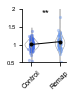

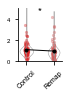

In [ ]:
ratios_remap_SST = np.array(remap_n_SST) / np.array(remap_f_SST)
ratios_reg_SST = np.array(reg_n_SST) / np.array(reg_f_SST)
ratios_remap_CKII = np.array(remap_n_CKII) / np.array(remap_f_CKII)
ratios_reg_CKII = np.array(reg_n_CKII) / np.array(reg_f_CKII)
alp = 0.4
size = 10
jitter_size = 0.03
figsize_mm = (20, 25)
figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)
fig,ax=plt.subplots(figsize=figsize_inch)
sns.violinplot(data=[ratios_reg_SST, ratios_remap_SST], color='white', linewidth=0.5, width=0.5, zorder=0, alpha=1)
jitter_reg_SST = np.random.normal(0, jitter_size, size=len(ratios_reg_SST))
jitter_remap_SST = np.random.normal(1, jitter_size, size=len(ratios_remap_SST))
plt.scatter(jitter_reg_SST, ratios_reg_SST, color=IN_COLOR, zorder=1, label='Non-tuned', alpha=alp, linewidths=0, s=size)
plt.scatter(jitter_remap_SST, ratios_remap_SST, color=IN_COLOR_weak, zorder=1, alpha=alp, linewidths=0, s=size)
#connect and plot means
plt.plot([0, 1], [np.mean(ratios_reg_SST), np.mean(ratios_remap_SST)], color='k', linestyle='-', linewidth=1, marker='o', markersize=3,zorder=10)
plt.ylim(0.5, 2)
plt.xticks([0, 1], ['Control', 'Remap'], fontsize=SVG_LABELS, rotation=45)
plt.yticks([0.5, 1, 1.5, 2], [0.5, 1, 1.5, 2], fontsize=SVG_TICKS)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylabel('FR ratio\n regs=' +str(len(ratios_reg_SST))+' ,remaps=' + str(len(ratios_remap_SST)), fontsize=10)
print("SSTs:")
print(stats.ranksums(ratios_remap_SST,ratios_reg_SST))
plt.text(0.5, 1.8, '**', fontsize=10, color='k', ha='center')
#remove background
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)

figsize_mm = (20, 25)
figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)
fig,ax=plt.subplots(figsize=figsize_inch)
sns.violinplot(data=[ratios_reg_CKII, ratios_remap_CKII], color='white', linewidth=0.5, width=0.5, zorder=0, alpha=1)
jitter_reg_CKII = np.random.normal(0, jitter_size, size=len(ratios_reg_CKII))
jitter_remap_CKII = np.random.normal(1, jitter_size, size=len(ratios_remap_CKII))
plt.scatter(jitter_reg_CKII, ratios_reg_CKII, color=PYR_COLOR, zorder=1, label='Non-tuned', alpha=alp, linewidths=0, s=size)
plt.scatter(jitter_remap_CKII, ratios_remap_CKII, color=PYR_COLOR_weak, zorder=1, alpha=alp, linewidths=0, s=size)
#connect and plot means
plt.plot([0, 1], [np.mean(ratios_reg_CKII), np.mean(ratios_remap_CKII)], color='k', linestyle='-', linewidth=1, marker='o', markersize=3,zorder=10)
plt.ylim(0, 8)
plt.xticks([0, 1], ['Control', 'Remap'], fontsize=SVG_LABELS, rotation=45)   
plt.yticks([0, 2, 4, 6, 8], [0, 2, 4, 6, 8], fontsize=SVG_TICKS)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylabel('FR ratio\n regs=' +str(len(ratios_reg_CKII))+' ,remaps=' + str(len(ratios_remap_CKII)), fontsize=10)
print("CKIIs:")
print(stats.ranksums(ratios_remap_CKII,ratios_reg_CKII))
plt.text(0.5, 4.5, '*', fontsize=10, color='k', ha='center')
plt.ylim(0, 5)
#remove background
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
print ("SST Remap n =",len(ratios_remap_SST),"SST Control n =",len(ratios_reg_SST))
print ("CKII Remap n =",len(ratios_remap_CKII),"CKII Control n =",len(ratios_reg_CKII))
#print means and SEMs rounded to 3 decimal places
print("SST Remap mean =",round(np.mean(ratios_remap_SST),3),"SST Remap SEM =",round(stats.sem(ratios_remap_SST),3))
print("SST Control mean =",round(np.mean(ratios_reg_SST),3),"SST Control SEM =",round(stats.sem(ratios_reg_SST),3))
print("CKII Remap mean =",round(np.mean(ratios_remap_CKII),3),"CKII Remap SEM =",round(stats.sem(ratios_remap_CKII),3))
print("CKII Control mean =",round(np.mean(ratios_reg_CKII),3),"CKII Control SEM =",round(stats.sem(ratios_reg_CKII),3))





## Speed per lap

In [ ]:
def get_speed_per_lap_on_df(cell,df=None):
    if df is None:
        df=cell.exp.data
    avg_speed_per_lap=[]
    laps=df['lap_counter'].unique()
    for lap in laps:
        df_lap=df[df['lap_counter']==lap]
        avg_speed_current_lap=np.mean(df_lap['speed'])
        avg_speed_per_lap.append(avg_speed_current_lap)
    return np.array(avg_speed_per_lap)

In [ ]:
#FR per lap by mouse, using only experiment with >10 laps in each environment - rewriting the code 
laps_to_consider=10
remap_n_mat=[];reg_n_mat=[];remap_f_mat=[];reg_f_mat=[]
for cell in result.keys():
    if cell.session_num==0:
            fam_df, nov_df = get_fam_and_novel_df_partial_new(cell,laps_to_consider=laps_to_consider)
            # check the number of spikes in each lap of "lap_counter" column
            n_fr_per_lap=get_speed_per_lap_on_df(cell,nov_df)
            f_fr_per_lap=get_speed_per_lap_on_df(cell,fam_df)

            f_fr_per_lap_to_norm=f_fr_per_lap.copy()
            f_fr_per_lap=f_fr_per_lap/np.mean(f_fr_per_lap)
            n_fr_per_lap=n_fr_per_lap/np.mean(f_fr_per_lap_to_norm) # added these line 30.9.24 to re check the normalization


            if len(n_fr_per_lap)!=laps_to_consider or len(f_fr_per_lap)!=laps_to_consider:
                continue

                
            if cell.remapping:
                remap_f_mat.append(f_fr_per_lap)
                remap_n_mat.append(n_fr_per_lap)
            else:
                reg_f_mat.append(f_fr_per_lap)
                reg_n_mat.append(n_fr_per_lap)



        




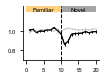

In [ ]:
#plotting in figure format
avg_f=np.nanmean(remap_f_mat,axis=0)
avg_n=np.nanmean(remap_n_mat,axis=0)
avg_fr=np.concatenate((avg_f,avg_n))
#add sem as error bars
sem_f=stats.sem(remap_f_mat,axis=0,nan_policy='omit')
sem_n=stats.sem(remap_n_mat,axis=0,nan_policy='omit')
sem_fr=np.concatenate((sem_f,sem_n))

avg_f_control=np.nanmean(reg_f_mat,axis=0)
avg_n_control=np.nanmean(reg_n_mat,axis=0)
avg_fr_control=np.concatenate((avg_f_control,avg_n_control))
#add sem as error bars
sem_f_control=stats.sem(reg_f_mat,axis=0,nan_policy='omit')
sem_n_control=stats.sem(reg_n_mat,axis=0,nan_policy='omit')
sem_fr_control=np.concatenate((sem_f_control,sem_n_control))


#to svg format
figsize_mm = (35, 25)
figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)
fig,ax=plt.subplots(figsize=figsize_inch)
ax.errorbar(np.arange(1,21),avg_fr, yerr=sem_fr, color='k',linewidth=1)
ax.plot(np.arange(1,21),avg_fr,color='k',linewidth=1)
ax.errorbar(np.arange(1,21),avg_fr_control, yerr=sem_fr_control, color='0.6',linewidth=1,alpha=0.3)
ax.plot(np.arange(1,21),avg_fr_control,color='0.6',linewidth=1,alpha=0.3)


plt.yticks([0.8,1],fontsize=SVG_TICKS)
plt.ylim(0.7,1.25)
plt.xticks([0,5,10,15,20],fontsize=SVG_TICKS)

max_y=np.max(avg_fr_control+sem_fr_control)

## Span coloring for familiar and novel

plt.axvspan(0, 10, facecolor='orange', alpha=0.5,ymin=0.9, ymax=1)
plt.axvspan(10, 20, facecolor='0.3', alpha=0.5,ymin=0.9, ymax=1)
# Get current ylim (after setting max_y)
ylim_lower, ylim_upper = plt.ylim()
range = ylim_upper - ylim_lower

# # Adding text in the middle of the spans
plt.text(5, ylim_upper-range*0.06 , 'Familiar', color='black', fontsize=SVG_TICKS, ha='center', va='center')
plt.text(15, ylim_upper-range*0.06 , 'Novel', color='black', fontsize=SVG_TICKS, ha='center', va='center')
#removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#remove background
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.axvline(10, color='k', linestyle='--', linewidth=1)
plt.show()

    

